In [1]:
%matplotlib ipympl

# Lattice design with Xsuite

We will uses as example the PIMM lattice developed by the TERA collaboration for proton and ion therapy ([CERN/PS 99-010](https://cds.cern.ch/record/385378/)) and implemented in the CNAO and MEDAUSTRON sysntrotrons.

In [2]:
import matplotlib.pyplot as plt
import xtrack as xt
import numpy as np

### Build Xsuite environment and define a reference particle

In [3]:
env = xt.Environment()
env.set_particle_ref('proton', kinetic_energy0=200e6)

In [4]:
env.vars.default_to_zero = True # Undefined variables in env are automatically 
                                # set to zero.

### Define elements

In [5]:
# Element geometry
n_bends = 16
env['ang_mb'] = 2*np.pi/n_bends
env['l_mb'] = 1.65
env['l_mq'] = 0.35

env.new('mb', xt.RBend, length_straight='l_mb', angle='ang_mb')
env.new('mq', xt.Quadrupole, length='l_mq');

In [6]:
# Quadrupole families with different strengths
env.new('qfa', 'mq', k1= 'kqfa')
env.new('qfb', 'mq', k1= 'kqfb')
env.new('qd',  'mq', k1= 'kqd');

### Build lattice cells

In [7]:
cell_a = env.new_line(length=7.405, components=[
    env.place('qfa', at=0.3875),
    env.place('mb', at=1.8125),
    env.place('qd', at=3.2925),
    env.place('mb', at=5.0475),
    env.place('qfa', at=6.3275),
])

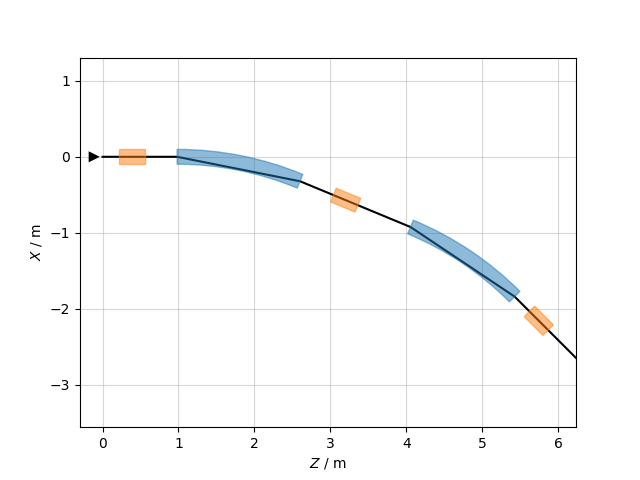

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


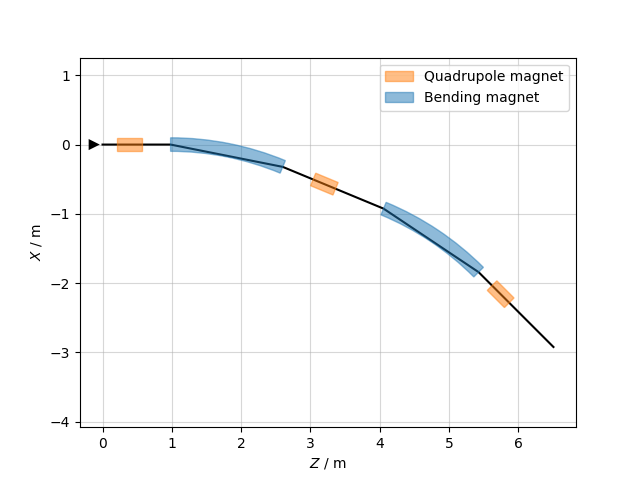

In [8]:
cell_a.survey().plot()

In [9]:
cell_b = env.new_line(name='cell_b', length=8.405, components=[
    env.place('qfb', at=1.2725),
    env.place('mb', at= 2.7275),
    env.place('qd', at=4.8575),
    env.place('mb', at=6.5125),
    env.place('qfb', at=7.7925),
])

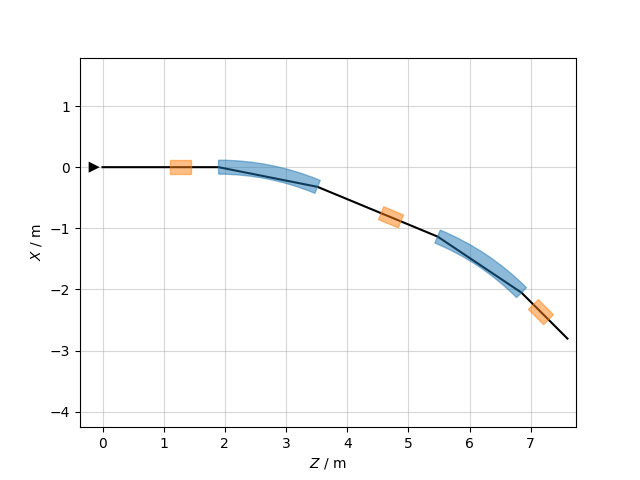

In [10]:
cell_b.survey().plot()

### Build an arc

In [11]:
# concatenate the two cells
arc = cell_a + cell_b 

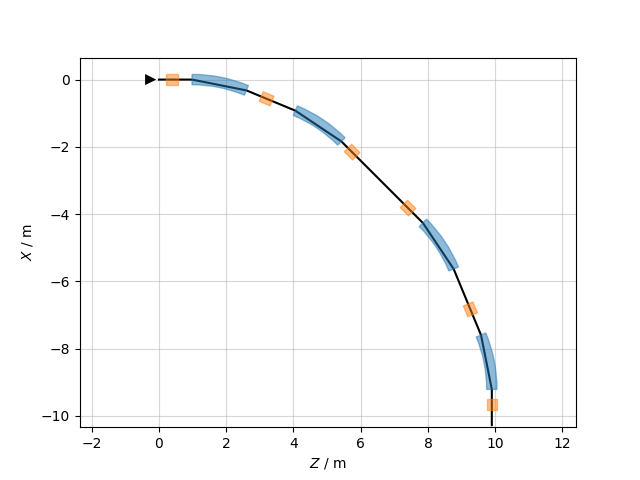

In [12]:
arc.survey().plot()

### Build a straight sections

In [13]:
long_straight = env.new_line(length=2., components=[
    env.new('mid.lss', xt.Marker, at=1.)
])
short_straight = env.new_line(length=1., components=[
    env.new('mid.sss', xt.Marker, at=1.)
])

### Assemble the ring

In [14]:
half_ring = (long_straight
             + arc
             + short_straight
             - arc # mirror symmetric lattice
            )

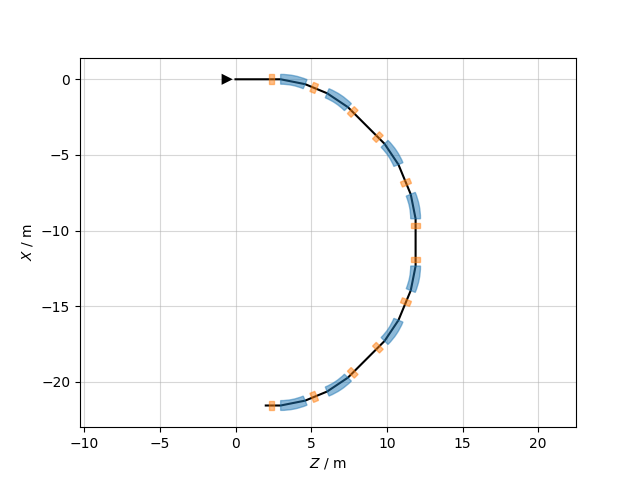

In [15]:
half_ring.survey().plot()

In [16]:
ring = 2 * half_ring

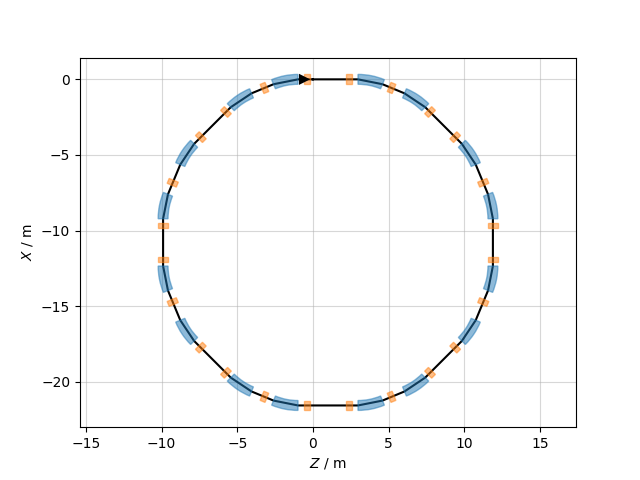

In [17]:
ring.survey().plot()

### Replace repeated elements

In [18]:
ring.replace_all_repeated_elements() # give all elements unique names

### Inspect beamline table

In [19]:
tt = ring.get_table()
tt.cols['element_type s_start s_center s_end']

Table: 99 rows, 5 cols
name          element_type       s_start      s_center         s_end
||drift_13::0 Drift                    0           0.5             1
mid.lss.0     Marker                   1             1             1
||drift_13::1 Drift                    1           1.5             2
||drift_1::0  Drift                    2       2.10625        2.2125
qfa.0         Quadrupole          2.2125        2.3875        2.5625
||drift_2::0  Drift               2.5625       2.77234       2.98218
mb.0          RBend              2.98218        3.8125       4.64282
||drift_3::0  Drift              4.64282       4.88016        5.1175
qd.0          Quadrupole          5.1175        5.2925        5.4675
||drift_4::0  Drift               5.4675       5.84234       6.21718
...
||drift_5::3 Drift              63.0875       63.2248       63.3622
mb.14        RBend              63.3622       64.1925       65.0228
||drift_4::3 Drift              65.0228       65.3977       65.7725
qd.7      

In [20]:
# Inspect all quadrupoles
tt_quad = tt.rows[tt.element_type=='Quadrupole']
tt_quad.cols['s_start s_center s_end']

Table: 24 rows, 4 cols
name        s_start      s_center         s_end
qfa.0        2.2125        2.3875        2.5625
qd.0         5.1175        5.2925        5.4675
qfa.1        8.1525        8.3275        8.5025
qfb.0       10.5025       10.6775       10.8525
qd.1        14.0875       14.2625       14.4375
qfb.1       17.0225       17.1975       17.3725
qfb.2       19.2475       19.4225       19.5975
qd.2        22.1825       22.3575       22.5325
qfb.3       25.7675       25.9425       26.1175
qfa.2       28.1175       28.2925       28.4675
qd.3        31.1525       31.3275       31.5025
qfa.3       34.0575       34.2325       34.4075
qfa.4       36.8325       37.0075       37.1825
qd.4        39.7375       39.9125       40.0875
qfa.5       42.7725       42.9475       43.1225
qfb.4       45.1225       45.2975       45.4725
qd.5        48.7075       48.8825       49.0575
qfb.5       51.6425       51.8175       51.9925
qfb.6       53.8675       54.0425       54.2175
qd.6        56.80

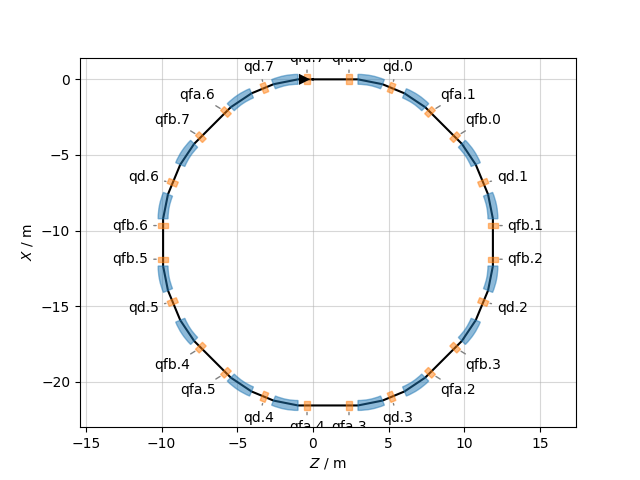

In [21]:
# Tag all quadrupoles in survey plot
sv = ring.survey()
sv.plot(labels=tt_quad.name);

### Define and install sextupoles

In [22]:
# Magnet type
env.new('ms', xt.Sextupole, length=0.2)

# Magnet instances
env.new('msf.1', 'ms', k2='ksf')
env.new('msf.2', 'ms', k2='ksf')
env.new('msd.1', 'ms', k2='ksd')
env.new('msd.2', 'ms', k2='ksd')
env.new('mse',   'ms', k2='kse');

In [23]:
ring.insert([
    env.place('msf.1', at=-0.2, from_='qfb.0@start'),
    env.place('msf.2', at=-0.2, from_='qfb.4@start'),
    env.place('msd.1', at=0.3,  from_='qd.2@end'),
    env.place('msd.2', at=0.3,  from_='qd.6@end'),
    env.place('mse',   at=-0.3, from_='qfa.4@start')
])

Slicing line:   0%|          | 0/98 [00:00<?, ?it/s]

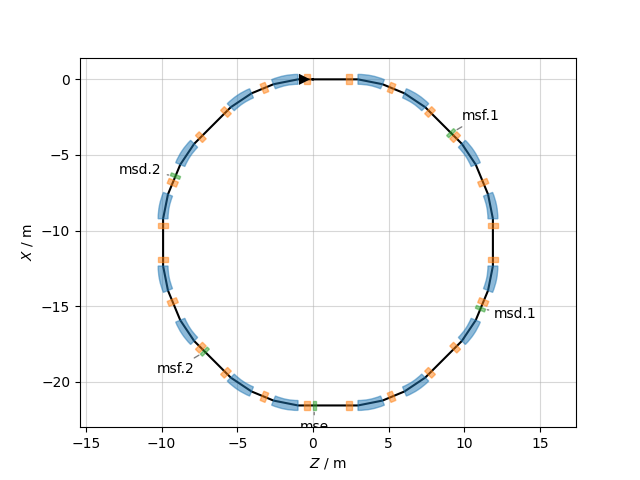

In [24]:
# Inspect sextupoles in the survey
sv = ring.survey()
sv.plot(labels=['msf.1', 'msf.2', 'msd.1', 'msd.2', 'mse'])

## Inspect circuit structure

In [25]:
# Entities contrilled by one knob
env.info('ksf')

#  vars['ksf']._get_value()
   vars['ksf'] = 0.0

#  vars['ksf']._expr is None

#  vars['ksf']._find_dependant_targets()
   element_refs['msf.2'].k2
   element_refs['msf.1'].k2



In [26]:
# Inspect knob controlling one magnet
env.info('msf.1')

Element of type:  Sextupole
name                value                                                       expr       
k2                  0.0                                                         vars['ksf']
k2s                 0.0                                                         None       
length              0.2                                                         None       
order               5                                                           None       
inv_factorial_order 0.008333333333333333                                        None       
knl                 [0. 0. 0. 0. 0. 0.]                                         None       
ksl                 [0. 0. 0. 0. 0. 0.]                                         None       
edge_entry_active   0                                                           None       
edge_exit_active    0                                                           None       
num_multipole_kicks 0                               

### Install RF cavity

In [27]:
env.new('rf1', xt.Cavity, voltage='vrf', frequency='frf')
ring.insert('rf1', at=0.5, from_='qfa.3@start')

Slicing line:   0%|          | 0/107 [00:00<?, ?it/s]

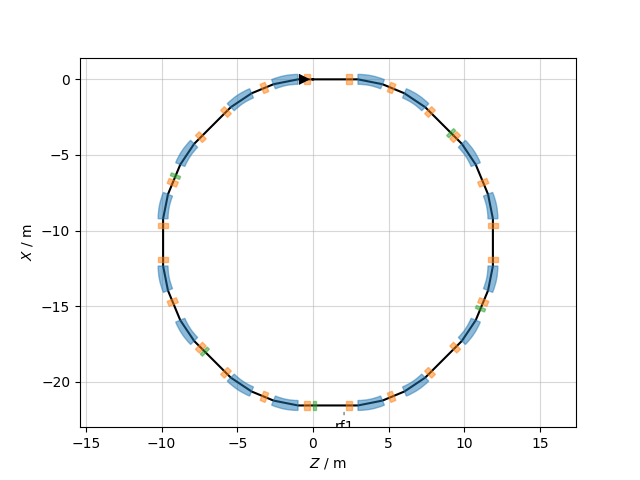

In [28]:
sv = ring.survey()
sv.plot(labels=['rf1'])

### Save lattice to json file

In [29]:
env['ring'] = ring
env.to_json('pimm.json')